# Libraries Import

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split

from skimage import io, color #Scikit-Image
from PIL import Image # Pillow
import cv2

import os
import random

import torch # Will work on using PyTorch here later
from torch.utils.data  import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from google.colab import drive

print(torch.__version__)

1.13.0+cu116


In [4]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
parent_folder = '/content/gdrive/MyDrive/HC18'
data_folder = '/content/gdrive/MyDrive/HC18/data'

# Load Datasets

In [6]:
class HC18(Dataset):
    def __init__(self, train = True, transformX = None, transformY = None):
        self.pixel_file = pd.read_csv(os.path.join(data_folder, 'training_set_pixel_size_and_HC.csv'))
        self.transformX = transformX
        self.transformY = transformY
        self.train = train
        self.train_data, self.validation_data = train_test_split(self.pixel_file, test_size = validation_set_size, random_state = 5)

    def __len__(self):
        if self.train:
            return len(self.train_data)
        return len(self.validation_data)
    
    def __getitem__(self, index):
        if self.train:
            imx_name = os.path.join(data_folder, 'training_set', self.train_data.iloc[index, 0])
            imy_name = os.path.join(data_folder, 'training_set', self.train_data.iloc[index, 0].replace('.png','_Annotation.png'))
        else:
            imx_name = os.path.join(data_folder, 'training_set', self.validation_data.iloc[index, 0])
            imy_name = os.path.join(data_folder, 'training_set', self.validation_data.iloc[index, 0].replace('.png','_Annotation.png'))
        imx = Image.open(imx_name)
        imy = Image.open(imy_name).convert('L')
        
        ## tried some data augmentation techniques
        if self.train:
          # Random horizontal flipping
          if random.random() > 0.5:
              imx = TF.hflip(imx)
              imy = TF.hflip(imy)

          # Random vertical flipping
          if random.random() > 0.5:
              imx = TF.vflip(imx)
              imy = TF.vflip(imy)

          # Random rotation
          if random.random() > 0.8:
            angle = random.choice([-30, -90, -60, -45 -15, 0, 15, 30, 45, 60, 90])
            imx = TF.rotate(imx, angle)
            imy = TF.rotate(imy, angle)
        
        # We will use resize, tensorlize, and normalize in the following cell
        if self.transformX :
            imx = self.transformX(imx)
            imy = self.transformY(imy)
        
        sample = {'image': imx, 'annotation': imy}
        return sample

In [7]:
with open(os.path.join(parent_folder, 'train_data.pickle'), 'rb') as f:
    train_data = pickle.load(f)
with open(os.path.join(parent_folder, 'validation_data.pickle'), 'rb') as f:
    validation_data = pickle.load(f)

In [8]:
# Dataloaders
train_loader = DataLoader(dataset = train_data, batch_size = 2)
validation_loader = DataLoader(dataset = validation_data, batch_size = 2)

# Build the Model

In [9]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            #nn.Dropout2d(0.7),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            #nn.Dropout2d(0.77),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x

class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2), 
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()
        if bilinear: 
            self.up = nn.Upsample(
                scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [10]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256, bilinear = False)
        self.up2 = up(512, 128, bilinear = False)
        self.up3 = up(256, 64, bilinear = False)
        self.up4 = up(128, 64, bilinear = False)
        self.outc = outconv(64, n_classes)
        self.dropout = torch.nn.Dropout2d(0.5)

    def forward(self, x):
        x = x.float()
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.dropout(x)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)

In [11]:
model = UNet(1, 1)
model.to('cuda')
print("Model Loaded to GPU")

Model Loaded to GPU


In [12]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [13]:
# calculates similarity index between predicted and actual segmentation
def dice_index(y_pred, y_actual):
    smooth = 0.000001
    size_of_batch = y_pred.size(0)
    
    p1 = y_pred.view(size_of_batch, -1)
    p2 = y_actual.view(size_of_batch, -1)
    
    intersection = (p1 * p2).sum()
    
    dice =  ((2.0 * intersection )+ smooth) / (p1.sum() + p2.sum() + smooth)
    #dice.requires_grad = True
    
    return dice

# calculate dice loss which will be later used in loss function calculation
def dice_loss(y_predict, y_train): ## to add in bce looss
    return 1 -(dice_index(y_predict, y_train))

# Only train the model if you want to retrain, screw down to load the pre-trained model

In [ ]:
epochs = 20 

train_running_loss_history = []
validation_running_loss_history =[]

for e in range(epochs):
    train_running_loss = 0.0
    validation_running_loss = 0.0  
    model.train()
    for ith_batch, sample_batched in enumerate(train_loader):
        X_train = sample_batched['image'].cuda()
        y_train = sample_batched['annotation'].to("cuda:0")
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = 0.30 * dice_loss(y_pred, y_train) +  0.70 * criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        if ith_batch % 50 == 0:
            print('Epoch: ', e + 1, 'Batch: ', ith_batch, 'Current Loss: ', loss.item())
        train_running_loss += loss.item()
    else:
        with torch.no_grad():
            model.eval()
            for ith_batch, sample_batched in enumerate(validation_loader):
                X_val = sample_batched['image'].cuda()
                y_val = sample_batched['annotation'].to("cuda:0")
                y_out = model(X_val)
                out_val = (y_out + 0.5).int().float()
                val_loss = 0.3 * dice_loss(out_val, y_val)  + 0.7 * criterion(y_out, y_val)
                validation_running_loss += val_loss.item()
            print("================================================================================")
            print("Epoch {} completed".format(e + 1))

            train_epoch_loss = train_running_loss / len(train_loader)
            validation_epoch_loss = validation_running_loss / len(validation_loader)

            print("Average train loss is {}: ".format(train_epoch_loss))
            print("Average validation loss is {}".format(validation_epoch_loss))
            print("================================================================================")
            train_running_loss_history.append(train_epoch_loss)
            validation_running_loss_history.append(validation_epoch_loss)

    torch.cuda.empty_cache()

Epoch:  1 Batch:  0 Current Loss:  0.6433738470077515
Epoch:  1 Batch:  50 Current Loss:  0.4641196131706238
Epoch:  1 Batch:  100 Current Loss:  0.380474328994751
Epoch:  1 Batch:  150 Current Loss:  0.4855611324310303
Epoch:  1 Batch:  200 Current Loss:  0.23920778930187225
Epoch:  1 Batch:  250 Current Loss:  0.2878831923007965
Epoch:  1 Batch:  300 Current Loss:  0.2290586233139038
Epoch:  1 Batch:  350 Current Loss:  0.2021007090806961
Epoch 1 completed
Average train loss is 0.3392075290158391: 
Average validation loss is 0.23661553367972374
Epoch:  2 Batch:  0 Current Loss:  0.4294271469116211
Epoch:  2 Batch:  50 Current Loss:  0.3727321922779083
Epoch:  2 Batch:  100 Current Loss:  0.177557572722435
Epoch:  2 Batch:  150 Current Loss:  0.3599812984466553
Epoch:  2 Batch:  200 Current Loss:  0.15867923200130463
Epoch:  2 Batch:  250 Current Loss:  0.22639372944831848
Epoch:  2 Batch:  300 Current Loss:  0.16440246999263763
Epoch:  2 Batch:  350 Current Loss:  0.16935789585113525

Epoch:  12 Batch:  250 Current Loss:  0.07660360634326935
Epoch:  12 Batch:  300 Current Loss:  0.0519089512526989
Epoch:  12 Batch:  350 Current Loss:  0.0540185309946537
Epoch 12 completed
Average train loss is 0.08360550140962004: 
Average validation loss is 0.13781525341793896
Epoch:  13 Batch:  0 Current Loss:  0.15992102026939392
Epoch:  13 Batch:  50 Current Loss:  0.09184205532073975
Epoch:  13 Batch:  100 Current Loss:  0.04061045125126839
Epoch:  13 Batch:  150 Current Loss:  0.06440312415361404
Epoch:  13 Batch:  200 Current Loss:  0.04923461377620697
Epoch:  13 Batch:  250 Current Loss:  0.09414017200469971
Epoch:  13 Batch:  300 Current Loss:  0.05911192670464516
Epoch:  13 Batch:  350 Current Loss:  0.052150193601846695
Epoch 13 completed
Average train loss is 0.07796593022998423: 
Average validation loss is 0.0820119304023683
Epoch:  14 Batch:  0 Current Loss:  0.12364372611045837
Epoch:  14 Batch:  50 Current Loss:  0.07903099060058594
Epoch:  14 Batch:  100 Current Los

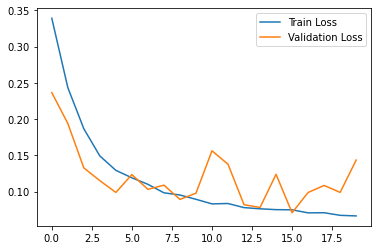

In [ ]:
plt.plot(train_running_loss_history, label = 'Train Loss')
plt.plot(validation_running_loss_history, label = 'Validation Loss')
plt.legend()

In [ ]:
model.eval()
X_train.size()

torch.Size([1, 1, 572, 572])

In [ ]:
torch.save(model, os.path.join(parent_folder, 'savedmodel/UNet.pt'))

# You can load a model instead

In [22]:
model = torch.load(os.path.join(parent_folder, 'savedmodel/UNet.pt'))
model.to('cuda')
model.eval()

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2

In [23]:
def avg_dice_index(dataloader):
    dice = 0.0
    model.eval()
    with torch.no_grad():
        for ith_batch, sample_batched in enumerate(dataloader):
            X_train = sample_batched['image'].to('cuda')
            y_train = sample_batched['annotation'].to('cuda')
            y_predict = (model(X_train) + 0.5).int().float()
            dice += dice_index(y_predict, y_train)
    avg_dice = dice / len(dataloader)
    return avg_dice.item()

In [24]:
avg_dice_index(validation_loader)    #### Dice index of validation data

0.9150426387786865

In [25]:
avg_dice_index(train_loader)    #### Dice index of train data

0.9025920629501343